# 🚢 Titanic Dataset - Feature Engineering Analysis

> **Author:** Arthur Gislon Leonida  
> **Course:** Algoritmos e Estruturas de Dados - UFSC  
> **Objective:** Predict passenger survival on the Titanic using advanced feature engineering techniques

---

## 📊 Dataset Overview

**Source:** [Kaggle Titanic Competition](https://www.kaggle.com/competitions/titanic)

### 🎯 Target Variable
- **`Survived`:** Survival status (0 = No, 1 = Yes)

### 📋 Feature Dictionary

| Feature | Description | Type |
|---------|-------------|------|
| **pclass** | Ticket class (1st, 2nd, 3rd) | Categorical |
| **sex** | Gender | Categorical |
| **age** | Age in years | Numerical |
| **sibsp** | Number of siblings/spouses aboard | Numerical |
| **parch** | Number of parents/children aboard | Numerical |
| **ticket** | Ticket number | Text |
| **fare** | Passenger fare | Numerical |
| **cabin** | Cabin number | Text |
| **embarked** | Port of embarkation (C=Cherbourg, Q=Queenstown, S=Southampton) | Categorical |

---

## 🎯 Analysis Workflow

1. **Data Loading & Exploration**
2. **Baseline Model Development**
3. **Feature Engineering Pipeline**
4. **Advanced Feature Selection**
5. **Model Comparison & Optimization**

In [38]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import shap
import ipykernel
from scipy.stats import boxcox
from helper_functions import robust_outlier_detection, hsic_from_scratch, OptimalMIEstimator
from sklearn import set_config
import optuna as opt

# This tells all scikit-learn transformers to output pandas DataFrames
set_config(transform_output="pandas")

print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("sklearn version:", sklearn.__version__)
print("xgboost version:", xgb.__version__)
print("numpy version:", np.__version__)
print("shap version:", shap.__version__)
print("optuna version:", opt.__version__)
print("ipykernel version:", ipykernel.__version__)
print('python version:', os.popen('python --version').read().strip())

pandas version: 2.2.3
matplotlib version: 3.10.1
seaborn version: 0.13.2
sklearn version: 1.6.1
xgboost version: 3.0.5
numpy version: 2.2.3
shap version: 0.48.0
optuna version: 4.5.0
ipykernel version: 6.30.1
python version: Python 3.13.1


In [39]:
features_description = {
    'PassengerId': 'Passenger ID',
    'Survived': 'Survival (0 = No; 1 = Yes)',
    'Pclass': 'Passenger Class (1st, 2nd, 3rd)',
    'Name': 'Passenger Name',
    'Sex': 'Gender',
    'Age': 'Age in years',
    'SibSp': 'Number of Siblings/Spouses Aboard',
    'Parch': 'Number of Parents/Children Aboard',
    'Ticket': 'Ticket Number',
    'Fare': 'Passenger Fare',
    'Cabin': 'Cabin Number',
    'Embarked': 'Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)'
}

In [40]:
# The downloaded dataset has a file named 'Salary Prediction of Data Professions.csv'
train_file_path = 'data/train.csv'
# test_file_path = 'data/test.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(train_file_path)
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Survived'])

# I won't use this because it doesn't have the target variable (it was made for kaggle competition)
# test_df = pd.read_csv(test_file_path)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [41]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## 🔧 Baseline Model Development

### 📝 Preprocessing Strategy
Creating a simple preprocessing pipeline without extensive feature engineering to establish a performance baseline.

**Approach:**
- **Numerical features:** Mean imputation
- **Categorical features:** Most frequent imputation + One-hot encoding
- **Dropped features:** Name, Ticket, Cabin (high cardinality/text data)

In [42]:
# 1. Define which columns are which type
numeric_features = []
categorical_features = []
for col in df_train.drop('Survived', axis=1).columns:
    # check col type
    if df_train[col].dtype == 'object':
        categorical_features.append(col)
    else:    
        numeric_features.append(col)

# 2. Create the preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3. Combine preprocessing steps into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # This ensures columns like 'Name', 'Ticket', and 'Cabin' are dropped
)

# 4. Create the final, simple baseline pipeline
baseline_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

### 🤖 Baseline Model Training

Training an XGBoost classifier with default parameters on the preprocessed features.

In [43]:
X_train_base = df_train.drop('Survived', axis=1)
y_train_base = df_train['Survived']
X_val_base = df_val.drop('Survived', axis=1)
y_val_base = df_val['Survived']

X_train_base_processed = baseline_pipeline.fit_transform(X_train_base)
X_val_base_processed = baseline_pipeline.transform(X_val_base)

In [44]:
# Train baseline model
baseline_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
baseline_model.fit(X_train_base_processed, y_train_base)

# Evaluate baseline model
preds_base = baseline_model.predict(X_val_base_processed)
baseline_accuracy = accuracy_score(y_val_base, preds_base)

print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")

Baseline Model Accuracy: 0.7263


### ⚙️ Hyperparameter Optimization

Using **Optuna** for automated hyperparameter tuning to maximize model performance.

**Optimization Strategy:**
- **Objective:** Minimize log loss
- **Search space:** Learning rate, max depth, regularization parameters
- **Trials:** 250 iterations with early stopping

In [45]:
def check_xgboost_gpu_support():
    """
    Checks if the installed XGBoost version can use the GPU.
    """
    try:
        # Create a dummy dataset
        X = np.random.rand(10, 10)
        y = np.random.randint(2, size=10)
        
        # Try to initialize and train a model with the GPU
        model = xgb.XGBClassifier(tree_method='hist', device='cuda')
        model.fit(X, y)
        
        print("✅ XGBoost can use the GPU.")
        return True
    except xgb.core.XGBoostError as e:
        # The error message will tell you if GPU support is missing
        print(f"❌ XGBoost cannot use the GPU. Error: {e}")
        return False

# Run the check
is_gpu_available = check_xgboost_gpu_support()

✅ XGBoost can use the GPU.


In [ ]:
from sklearn.model_selection import cross_val_score

def objective_cv(trial, X_train, y_train, device):
    """
    Cross-validation objective function for more robust hyperparameter optimization.
    """
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 1, 10),
        'alpha': trial.suggest_float('alpha', 0, 10),
        'device': device,
        'tree_method': 'hist',
        'random_state': 42
    }

    model = xgb.XGBClassifier(**params)
    # Use 5-fold cross-validation for more robust evaluation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    
    return -cv_scores.mean()

In [ ]:
device = "cuda" if is_gpu_available else "cpu"

print(device)

study = opt.create_study(direction='minimize')
study.optimize(
    lambda trial: objective_cv(
        trial, X_train_base_processed, y_train_base, X_val_base_processed, y_val_base, device
    ), 
    n_trials=200
)

print("\nBest hyperparameters found:")
print(study.best_params)

print("\nBest log loss on the test set:")
print(study.best_value)

[I 2025-09-29 11:41:04,394] A new study created in memory with name: no-name-ba1051cf-a141-4a95-b343-97f6dfaec580


cuda


[I 2025-09-29 11:41:05,777] Trial 0 finished with value: 0.4884790730141058 and parameters: {'n_estimators': 400, 'learning_rate': 0.03126145500102213, 'max_depth': 10, 'subsample': 0.9706701549393632, 'colsample_bytree': 0.9822973203714558, 'gamma': 1.987905942647601, 'lambda': 4.907782130398831, 'alpha': 9.922770648857803}. Best is trial 0 with value: 0.4884790730141058.
[I 2025-09-29 11:41:07,517] Trial 1 finished with value: 0.4746363402103135 and parameters: {'n_estimators': 400, 'learning_rate': 0.023937255127076937, 'max_depth': 9, 'subsample': 0.9990034507098532, 'colsample_bytree': 0.6099082858103283, 'gamma': 0.7579442672814962, 'lambda': 7.70403298706442, 'alpha': 1.3554811415282497}. Best is trial 1 with value: 0.4746363402103135.
[I 2025-09-29 11:41:10,145] Trial 2 finished with value: 0.4715160337859465 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0246590446067093, 'max_depth': 7, 'subsample': 0.6789128528012833, 'colsample_bytree': 0.9681156839870081, 'gamma


Best hyperparameters found:
{'n_estimators': 300, 'learning_rate': 0.028054868617999194, 'max_depth': 9, 'subsample': 0.6450780579994628, 'colsample_bytree': 0.6469103501487693, 'gamma': 0.6788933508047987, 'lambda': 2.2734696964712073, 'alpha': 2.7036548465497905}

Best log loss on the test set:
0.4609056353388497


In [48]:
best_params = {'n_estimators': 1000, 'learning_rate': 0.23365118857145223, 'max_depth': 9, 'subsample': 0.75145579953529, 'colsample_bytree': 0.6523535247547196, 'gamma': 0.3183456593143924, 'lambda': 9.134515570127483, 'alpha': 0.7795536835218464}


'''
baseline_model_tuned = xgb.XGBClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    lambda_=best_params['lambda'],
    alpha=best_params['alpha'],
    random_state=42,
    eval_metric='logloss'
)

'''
# Train baseline model with best hyperparameters
baseline_model_tuned = xgb.XGBClassifier(
    n_estimators=study.best_params['n_estimators'],
    learning_rate=study.best_params['learning_rate'],
    max_depth=study.best_params['max_depth'],
    subsample=study.best_params['subsample'],
    colsample_bytree=study.best_params['colsample_bytree'],
    gamma=study.best_params['gamma'],
    lambda_=study.best_params['lambda'],
    alpha=study.best_params['alpha'],
    random_state=42,
    eval_metric='logloss'
)

baseline_model_tuned.fit(X_train_base_processed, y_train_base)

# Evaluate baseline model
preds_base = baseline_model_tuned.predict(X_val_base_processed)
baseline_tuned_accuracy = accuracy_score(y_val_base, preds_base)

print(f"Baseline Tuned Model Accuracy: {baseline_tuned_accuracy:.4f}")

c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:46:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "lambda_" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Baseline Tuned Model Accuracy: 0.8156


### 📈 Feature Importance Analysis

Using **SHAP (SHapley Additive exPlanations)** to understand which features contribute most to model predictions.

**SHAP Benefits:**
- Model-agnostic explanations
- Individual prediction breakdowns
- Global feature importance ranking


SHAP with Baseline Model Summary Plot:


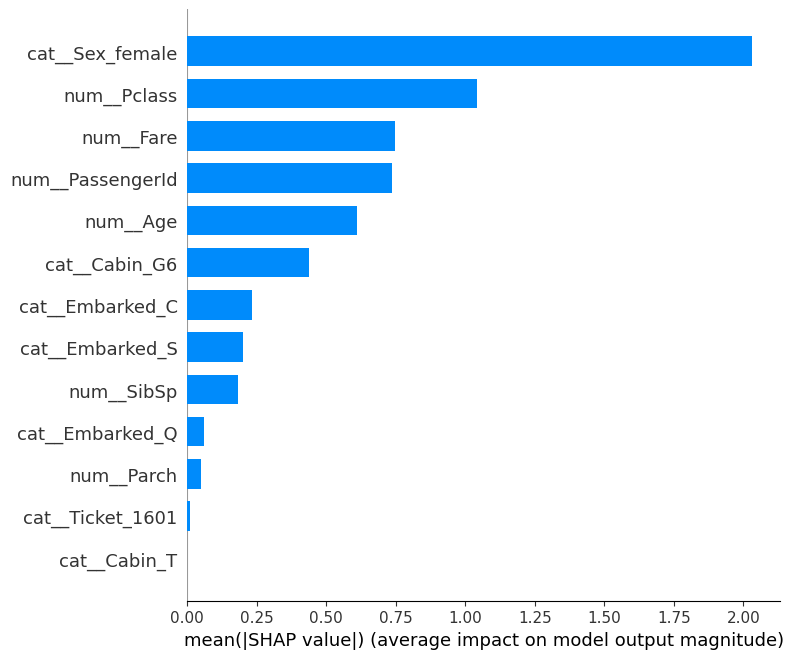

In [49]:
explainer = shap.Explainer(baseline_model, X_train_base_processed)
shap_values = explainer(X_val_base_processed)
print(f"\nSHAP with Baseline Model Summary Plot:")
shap.summary_plot(shap_values, X_val_base_processed, plot_type="bar", max_display=13)


SHAP with Tuned Baseline Model Summary Plot:


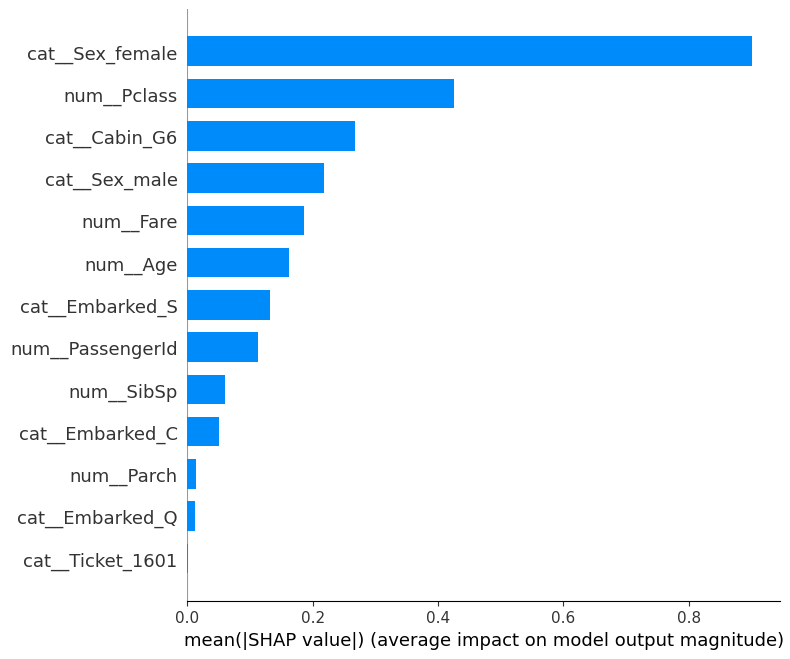

In [50]:
explainer = shap.Explainer(baseline_model_tuned, X_train_base_processed)
shap_values = explainer(X_val_base_processed)
print(f"\nSHAP with Tuned Baseline Model Summary Plot:")
shap.summary_plot(shap_values, X_val_base_processed, plot_type="bar", max_display=13)

# 🛠️ Advanced Feature Engineering Pipeline

## 🎨 Custom Transformer Classes

Creating specialized preprocessing classes to extract maximum value from the raw data.

### 🔍 Feature Engineering Strategies:

1. **Missing Value Imputation**
   - Age: Mean imputation
   - Embarked: Most frequent value

2. **Feature Creation**
   - Title extraction from names
   - Family size calculation
   - Cabin deck extraction
   - Alone passenger indicator

3. **Feature Encoding**
   - Label encoding for categorical variables
   - Preserving ordinal relationships

4. **Feature Selection**
   - Remove redundant/unhelpful columns

In [51]:
class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='mean')
    
    def fit(self, X, y=None):
        self.imputer.fit(X[['Age']])
        return self
    
    def transform(self, X):
        X = X.copy()
        X['Age'] = self.imputer.transform(X[['Age']])
        return X

class EmbarkedImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='most_frequent')
    
    def fit(self, X, y=None):
        self.imputer.fit(X[['Embarked']])
        return self
    
    def transform(self, X):
        X = X.copy()
        X['Embarked'] = self.imputer.transform(X[['Embarked']])
        return X

class TitleExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['Title'] = X['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
        common_titles = ['Mr', 'Miss', 'Mrs', 'Master']
        X['Title'] = X['Title'].apply(lambda x: x if x in common_titles else 'Other')
        return X

class FamilyFeatureCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Create the FamilySize feature
        X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
        
        # Create the IsAlone feature
        X['IsAlone'] = (X['FamilySize'] == 1).astype(int)
        
        return X

class CabinExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Fill missing cabins with 'U' for 'Unknown'
        cabins = X['Cabin'].fillna('U')
        
        # Extract the first letter as Cabin Deck
        X['CabinDeck'] = cabins.str[0]
        
        # Count the number of cabins
        X['CabinCount'] = X['Cabin'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

        return X

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.embarked_mapping = None
        self.sex_mapping = None
        self.title_mapping = None
        self.cabin_deck_mapping = None
    
    def fit(self, X, y=None):
        self.embarked_mapping = {'C': 0, 'Q': 1, 'S': 2}
        self.sex_mapping = {'female': 0, 'male': 1}
        self.title_mapping = {'Miss': 0, 'Mr': 1, 'Mrs': 2, 'Master': 3, 'Other': 4}
        
        # Learn cabin deck mapping from training data
        unique_decks = X['CabinDeck'].unique()
        self.cabin_deck_mapping = {deck: idx for idx, deck in enumerate(unique_decks)}
        return self

    def transform(self, X):
        X = X.copy()
        # Encode features using learned mappings
        X['Embarked'] = X['Embarked'].map(self.embarked_mapping)
        X['Sex'] = X['Sex'].map(self.sex_mapping)
        X['Title'] = X['Title'].map(self.title_mapping)
        X['CabinDeck'] = X['CabinDeck'].map(self.cabin_deck_mapping)
        return X

class FeatureScaler(BaseEstimator, TransformerMixin):
    """Applies StandardScaler to all numerical columns."""
    def __init__(self):
        self.scaler = StandardScaler()
        self.numerical_cols = []

    def fit(self, X, y=None):
        # Identify numerical columns to be scaled
        self.numerical_cols = X.drop('Survived', axis=1).select_dtypes(include=np.number).columns.tolist()
        if self.numerical_cols:
            self.scaler.fit(X[self.numerical_cols])
        return self

    def transform(self, X):
        if self.numerical_cols:
            X[self.numerical_cols] = self.scaler.transform(X[self.numerical_cols])
        return X

class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X):
        return X.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1, errors='ignore')

In [52]:
pipeline = Pipeline(steps=[
    # -- IMPUTATION --
    ('age_imputer', AgeImputer()),
    ('embarked_imputer', EmbarkedImputer()),
    # -- FEATURE CREATION (DATA AUGMENTATION) --
    ('family_feature_creator', FamilyFeatureCreator()),
    ('title_extractor', TitleExtractor()),
    ('cabin_extractor', CabinExtractor()),
  # -- ENCODING, SCALING AND DROPPING --
    ('feature_encoder', FeatureEncoder()),
  # ('feature_scaler', FeatureScaler()),
    ('feature_dropper', FeatureDropper())
])

# Create copies for the next feature engineering steps
df_eng_train = df_train.copy()
df_eng_val = df_val.copy()

df_eng_train = pipeline.fit_transform(df_eng_train)
df_eng_val = pipeline.transform(df_eng_val)

c:\Users\arthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [53]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [54]:
df_eng_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone,Title,CabinDeck,CabinCount
692,1,3,1,29.807687,56.4958,2,1,1,1,0,0
481,0,2,1,29.807687,0.0000,2,1,1,1,0,0
527,0,1,1,29.807687,221.7792,2,1,1,1,1,1
855,1,3,0,18.000000,9.3500,2,2,0,2,0,0
801,1,2,0,31.000000,26.2500,2,3,0,2,0,0


In [55]:
features = df_eng_train.drop(['Survived'], axis=1)
features.head()

,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone,Title,CabinDeck,CabinCount
692,3,1,29.807687,56.4958,2,1,1,1,0,0
481,2,1,29.807687,0.0000,2,1,1,1,0,0
527,1,1,29.807687,221.7792,2,1,1,1,1,1
855,3,0,18.000000,9.3500,2,2,0,2,0,0
801,2,0,31.000000,26.2500,2,3,0,2,0,0


## 📊 Data Distribution Analysis

Visualizing the distribution of engineered features to understand data characteristics and identify potential issues.

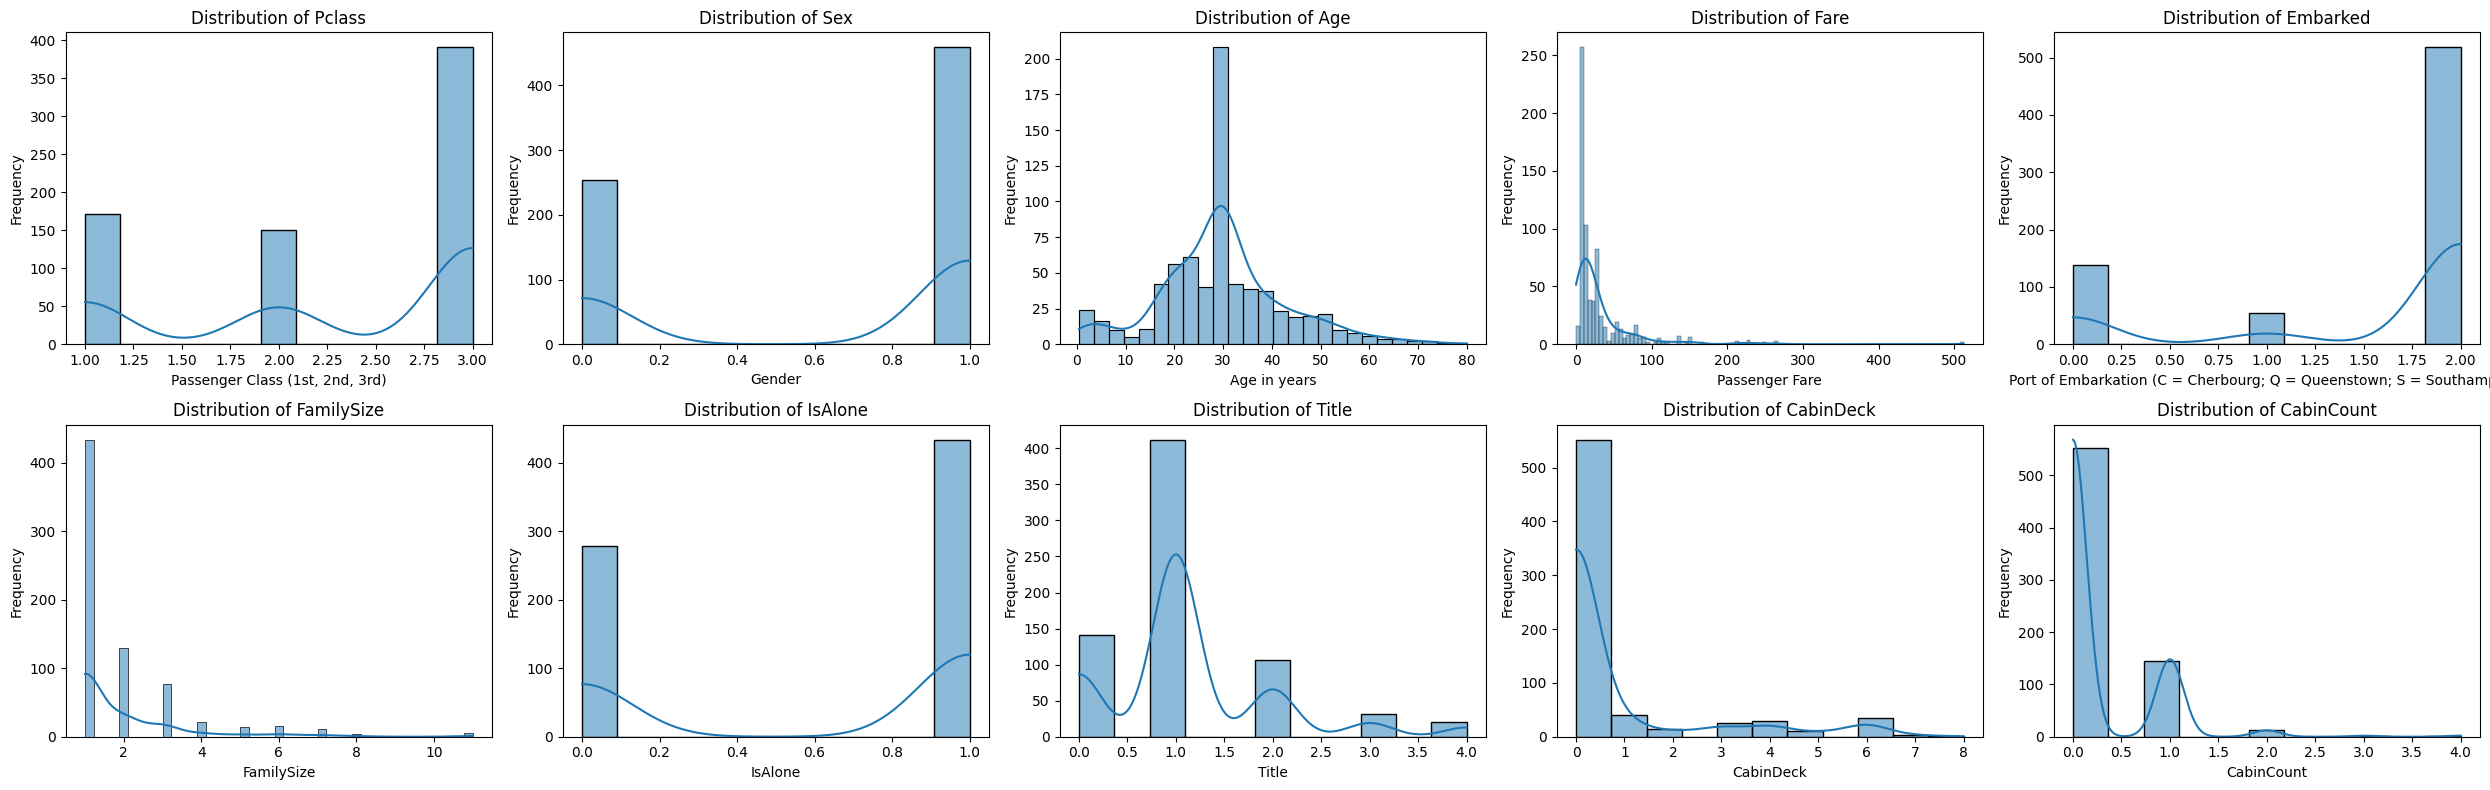

In [56]:
numeric_features = features.select_dtypes(include=['number']).columns
num_plots = len(numeric_features)
cols = 5
rows = (num_plots + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(numeric_features):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(df_eng_train[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(features_description.get(feature, feature))
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### 📐 Skewness Assessment

Analyzing feature skewness to determine which variables need transformation for better model performance.

**Skewness Thresholds:**
- **|skew| > 1.5:** Highly skewed (requires transformation)
- **1.0 < |skew| ≤ 1.5:** Moderately skewed
- **|skew| ≤ 1.0:** Approximately normal

In [57]:
numerical_features = df_eng_train.select_dtypes(include=np.number).columns
skewness = df_eng_train[numerical_features].skew().sort_values(ascending=False)

print("Skewness of Numerical Features:")
print(skewness)

# Identify highly skewed features
highly_skewed = skewness[abs(skewness) > 0.5]
print("\nFeatures with significant skew:")
print(highly_skewed)

Skewness of Numerical Features:
Fare          4.646190
FamilySize    2.718601
CabinCount    2.545818
CabinDeck     2.195185
Title         1.181335
Survived      0.480519
Age           0.392903
IsAlone      -0.450063
Sex          -0.605783
Pclass       -0.630589
Embarked     -1.253597
dtype: float64

Features with significant skew:
Fare          4.646190
FamilySize    2.718601
CabinCount    2.545818
CabinDeck     2.195185
Title         1.181335
Sex          -0.605783
Pclass       -0.630589
Embarked     -1.253597
dtype: float64


In [58]:
highly_skewed_features = skewness[(abs(skewness) > 1.5)].index.tolist()
print("\nTop 3 highly skewed features:", highly_skewed_features)

moderate_skewed_features = skewness[(abs(skewness) > 1) & (abs(skewness) <= 1.5)].index.tolist()
print("\nModerately skewed features:", moderate_skewed_features)


Top 3 highly skewed features: ['Fare', 'FamilySize', 'CabinCount', 'CabinDeck']

Moderately skewed features: ['Title', 'Embarked']


In [59]:
for feature in numeric_features:
    print(f"Feature: {feature}, Min: {df_eng_train[feature].min()}, Max: {df_eng_train[feature].max()}, Skewness: {skewness[feature]}")

Feature: Pclass, Min: 1, Max: 3, Skewness: -0.6305889933530613
Feature: Sex, Min: 0, Max: 1, Skewness: -0.6057829774753115
Feature: Age, Min: 0.42, Max: 80.0, Skewness: 0.3929032564092265
Feature: Fare, Min: 0.0, Max: 512.3292, Skewness: 4.64618995113625
Feature: Embarked, Min: 0, Max: 2, Skewness: -1.2535966557689548
Feature: FamilySize, Min: 1, Max: 11, Skewness: 2.7186010356500696
Feature: IsAlone, Min: 0, Max: 1, Skewness: -0.45006349054333794
Feature: Title, Min: 0, Max: 4, Skewness: 1.1813352313568966
Feature: CabinDeck, Min: 0, Max: 8, Skewness: 2.1951847557963102
Feature: CabinCount, Min: 0, Max: 4, Skewness: 2.5458179262975302


### 🔄 Skewness Correction Transformations

Applying appropriate transformations to reduce skewness and improve model performance.

**Transformation Strategy:**
- **Fare:** Box-Cox transformation (continuous, positive values)
- **Other skewed features:** Log1p transformation (handles zeros gracefully)

**Benefits:**
- Improved model convergence
- Better feature distribution
- Enhanced predictive power

In [60]:
# Apply Box-Cox transformation
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    """
    Applies the Box-Cox transformation to a list of specified numerical columns.
    """
    def __init__(self, features=None):
        # Store the list of feature names to be transformed
        self.features = features
        self.lambdas_ = {}

    def fit(self, X, y=None):
        # Learn the optimal lambda for each feature from the training data
        for feature in self.features:
            feature_data = X[feature] + 1  # Box-Cox requires positive values
            _, self.lambdas_[feature] = boxcox(feature_data)
        return self

    def transform(self, X):
        for feature in self.features:
            feature_data = X[feature] + 1
            # Apply the transformation using the lambda learned during fit
            X[feature] = boxcox(feature_data, lmbda=self.lambdas_[feature])
        return X

# Apply log1p transformation
def apply_log_transform(X):
    """Applies a log1p transformation."""
    return np.log1p(X)

In [61]:
features_to_bc_transform = ['Fare']
features_to_log_transform = ['FamilySize', 'CabinCount']

preprocessor = ColumnTransformer(
    transformers=[
        #('log_transformer', FunctionTransformer(apply_log_transform), features_to_log_transform),
        ('boxcox_transformer', BoxCoxTransformer(features=features_to_bc_transform), features_to_bc_transform)
    ],
    remainder='passthrough' # Keep other columns ('Age')
)

transform_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

df_eng_train = transform_pipeline.fit_transform(df_eng_train)
df_eng_val = transform_pipeline.transform(df_eng_val)

df_eng_train.columns = df_eng_train.columns.str.replace('remainder__', '').str.replace('log_transformer__', 'log_transformer_').str.replace('boxcox_transformer__', 'boxcox_transformer_')
df_eng_val.columns = df_eng_val.columns.str.replace('remainder__', '').str.replace('log_transformer__', 'log_transformer_').str.replace('boxcox_transformer__', 'boxcox_transformer_')

df_eng_train.head()

,boxcox_transformer_Fare,Survived,Pclass,Sex,Age,Embarked,FamilySize,IsAlone,Title,CabinDeck,CabinCount
692,3.486357,1,3,1,29.807687,2,1,1,1,0,0
481,0.000000,0,2,1,29.807687,2,1,1,1,0,0
527,4.431708,0,1,1,29.807687,2,1,1,1,1,1
855,2.140875,1,3,0,18.000000,2,2,0,2,0,0
801,2.922005,1,2,0,31.000000,2,3,0,2,0,0


### 📊 Post-Transformation Visualization

Comparing feature distributions after applying skewness corrections to validate transformation effectiveness.

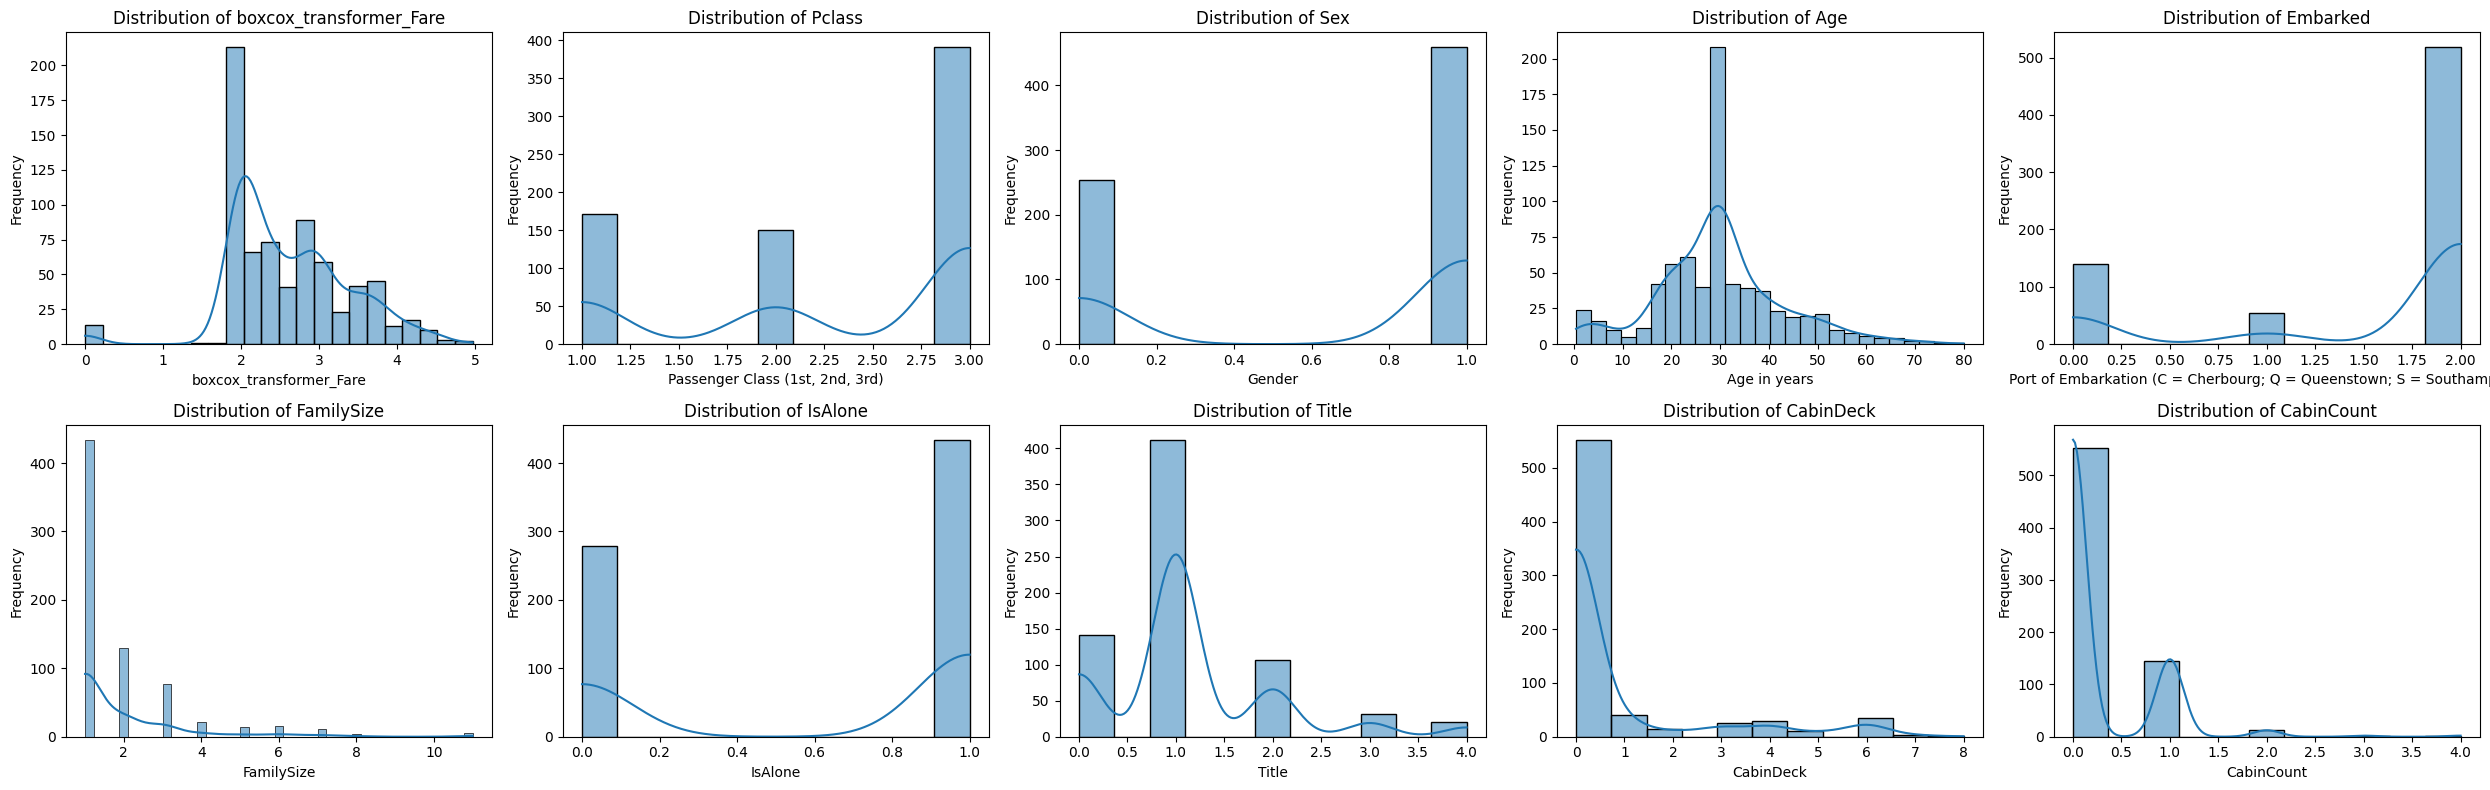

In [62]:
numeric_features = df_eng_train.drop(columns=['Survived']).select_dtypes(include=['number']).columns
num_plots = len(numeric_features)
cols = 5
rows = (num_plots + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(numeric_features):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(df_eng_train[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(features_description.get(feature, feature))
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### 🎯 Outlier Detection & Treatment

Using robust statistical methods to identify and handle outliers that could negatively impact model performance.

**Method:** Interquartile Range (IQR) with Winsorization
- **Detection:** Values beyond Q1 - 1.5×IQR or Q3 + 1.5×IQR
- **Treatment:** Cap extreme values at fence boundaries

In [63]:
for feature in df_eng_train.drop('Survived', axis=1).select_dtypes(include=['number']).columns:
    # print(f"Processing feature: {feature}")
    outliers = robust_outlier_detection(df_eng_train[feature])
    num_outliers = outliers.sum()
    if num_outliers > 0:
        print(f'Feature "{feature}" has {num_outliers} outliers detected.')

Feature "boxcox_transformer_Fare" has 16 outliers detected.
Feature "Age" has 29 outliers detected.
Feature "FamilySize" has 72 outliers detected.
Feature "Title" has 21 outliers detected.
Feature "CabinDeck" has 39 outliers detected.
Feature "CabinCount" has 16 outliers detected.


### 🔧 Winsorization Application

**Target Features:** Continuous variables only
- `boxcox_transformer_Fare`: Transformed fare values
- `Age`: Passenger age

**Rationale:** Winsorization preserves data distribution while removing extreme outliers that could skew model predictions.

Capping 'boxcox_transformer_Fare' at fences: [0.46, 4.60]
Capping 'Age' at fences: [1.00, 57.00]


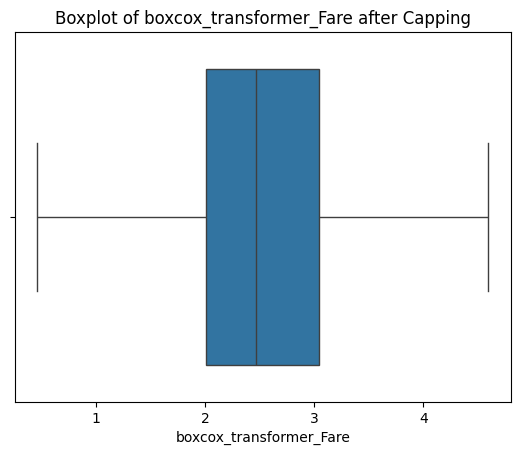

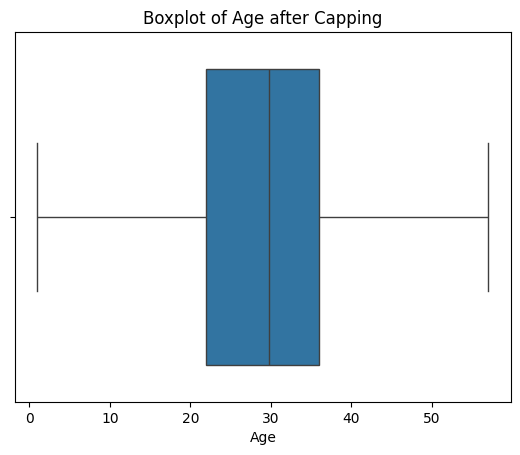

In [64]:
# Focus on the true numerical/continuous features from the list.
features_to_cap = ['boxcox_transformer_Fare', 'Age']

for feature in features_to_cap:
    if feature in df_eng_train.columns:
        # Define bounds using ONLY the training data
        Q1 = df_eng_train[feature].quantile(0.25)
        Q3 = df_eng_train[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_fence = Q1 - 1.5 * IQR
        upper_fence = Q3 + 1.5 * IQR
        
        print(f"Capping '{feature}' at fences: [{lower_fence:.2f}, {upper_fence:.2f}]")
        
        # Apply capping to both training and validation sets
        df_eng_train[feature] = np.clip(df_eng_train[feature], lower_fence, upper_fence)
        df_eng_val[feature] = np.clip(df_eng_val[feature], lower_fence, upper_fence)

for feature in features_to_cap:
    sns.boxplot(x=df_eng_train[feature])
    plt.title(f'Boxplot of {feature} after Capping')
    plt.show()

### ✅ Feature Engineering Consolidation

All feature engineering steps have been successfully applied and validated. The pipeline is now ready for feature selection and model training.

# 🔍 Intelligent Feature Selection

## 📊 Mutual Information + HSIC Analysis

Implementing advanced feature selection using two complementary methods:

### 🧮 **Mutual Information (MI)**
- Measures **statistical dependence** between features and target
- Captures both linear and non-linear relationships
- Higher values indicate stronger predictive power

### 🔗 **Hilbert-Schmidt Independence Criterion (HSIC)**
- Measures **independence** using kernel methods
- Complements MI by capturing different types of dependencies
- Robust to various data distributions

### 🎯 **Selection Strategy**
- Test different numbers of top features (k = 5 to all features)
- Combine top-k features from both MI and HSIC rankings
- Select the feature set that maximizes validation accuracy

In [65]:
def train_model(X_train, y_train, X_val, y_val, generalize=False):
    accuracy_list = []
    if generalize:
        for _ in range(10):  # Run 10 iterations for generalization
            final_model = xgb.XGBClassifier(eval_metric='logloss') # Removed random_state for generalization
            final_model.fit(X_train, y_train)
            preds_final = final_model.predict(X_val)
            final_accuracy = accuracy_score(y_val, preds_final)
            accuracy_list.append(final_accuracy)
    else:
        final_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss') # Removed random_state for generalization
        final_model.fit(X_train, y_train)
        preds_final = final_model.predict(X_val)
        final_accuracy = accuracy_score(y_val, preds_final)
        accuracy_list.append(final_accuracy)

    return np.mean(accuracy_list), final_model

In [66]:
len(df_eng_train.drop('Survived', axis=1).columns.tolist())

10

In [67]:
df_selection = df_eng_train.copy().drop(columns=['Survived'])
y_selection = df_eng_train['Survived'].copy()

# Initialize the OptimalMIEstimator with automatic method selection
mi_estimator = OptimalMIEstimator(method='auto')

# Calculate MI scores using the OptimalMIEstimator
mi_scores = {}
optimal_bins = {}
methods_used = {}

print("Calculating MI scores with optimal binning for each feature...")
for feature in df_selection.columns:
    mi_score, bins, method = mi_estimator.estimate(df_selection[feature].values, y_selection.values)
    mi_scores[feature] = mi_score
    optimal_bins[feature] = bins
    methods_used[feature] = method
    print(f"Feature '{feature}': MI={mi_score:.4f}, bins={bins}, method={method}")

# Convert to pandas Series for easier manipulation
mi_scores = pd.Series(mi_scores)

# Calculate HSIC scores (keeping original implementation)
hsic_scores = df_selection.apply(lambda x: hsic_from_scratch(x, y_selection), axis=0)

# Select top-k features
scores_df = pd.DataFrame({'MI': mi_scores, 'HSIC': hsic_scores}).sort_values(by='MI', ascending=False)

print(f"\nTop features by MI score:")
print(scores_df.head(10))

# --- Loop to Find Best Features ---
best_accuracy = 0
best_model = None
best_feature_set = []

for k in range(5, len(df_eng_train.drop('Survived', axis=1).columns.tolist()) + 1):
    top_mi = scores_df['MI'].nlargest(k).index
    top_hsic = scores_df['HSIC'].nlargest(k).index
    final_features = list(set(top_mi) | set(top_hsic))
    
    print(f"--- Testing with {len(final_features)} features (k={k}) ---")

    # Create training and validation sets with the selected features
    X_train_eng_subset = df_eng_train[final_features]
    y_train_eng = df_eng_train['Survived']
    X_val_eng_subset = df_eng_val[final_features]
    y_val_eng = df_eng_val['Survived']

    accuracy, model = train_model(X_train_eng_subset, y_train_eng, X_val_eng_subset, y_val_eng, generalize=True)
    
    print(f"Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        top_features_final = final_features

print("\n" + "="*40)
print(f"Best Model Accuracy after Feature Selection: {best_accuracy:.4f}")
print(f"Found with {len(top_features_final)} features:")
print(top_features_final)
print("="*40)


Calculating MI scores with optimal binning for each feature...
Feature 'boxcox_transformer_Fare': MI=0.0910, bins=27, method=sqrt
Feature 'Pclass': MI=0.0608, bins=8, method=fd
Feature 'Sex': MI=0.1543, bins=4, method=fd
Feature 'Age': MI=0.0380, bins=27, method=sqrt
Feature 'Embarked': MI=0.0175, bins=8, method=fd
Feature 'FamilySize': MI=0.0536, bins=44, method=fd
Feature 'IsAlone': MI=0.0231, bins=4, method=fd
Feature 'Title': MI=0.1690, bins=11, method=scott
Feature 'CabinDeck': MI=0.0674, bins=11, method=scott
Feature 'CabinCount': MI=0.0655, bins=19, method=scott


c:\Users\arthu\Documents\Estudos\UFSC\MATERIAS_POS\AlgoritmosDados\FeatureEngineering\helper_functions.py:150: RuntimeWarning: divide by zero encountered in scalar divide
  bins = int((np.max(x) - np.min(x)) / bin_width)
c:\Users\arthu\Documents\Estudos\UFSC\MATERIAS_POS\AlgoritmosDados\FeatureEngineering\helper_functions.py:150: RuntimeWarning: divide by zero encountered in scalar divide
  bins = int((np.max(x) - np.min(x)) / bin_width)
c:\Users\arthu\Documents\Estudos\UFSC\MATERIAS_POS\AlgoritmosDados\FeatureEngineering\helper_functions.py:150: RuntimeWarning: divide by zero encountered in scalar divide
  bins = int((np.max(x) - np.min(x)) / bin_width)



Top features by MI score:
                               MI      HSIC
Title                    0.169000  0.005419
Sex                      0.154343  0.010143
boxcox_transformer_Fare  0.091028  0.005046
CabinDeck                0.067400  0.002908
CabinCount               0.065467  0.003139
Pclass                   0.060769  0.006827
FamilySize               0.053603  0.001258
Age                      0.038049  0.000434
IsAlone                  0.023125  0.001624
Embarked                 0.017502  0.000839
--- Testing with 6 features (k=5) ---
Accuracy: 0.7709
--- Testing with 6 features (k=6) ---
Accuracy: 0.7709
--- Testing with 8 features (k=7) ---
Accuracy: 0.7542
--- Testing with 9 features (k=8) ---
Accuracy: 0.8212
--- Testing with 10 features (k=9) ---
Accuracy: 0.8045
--- Testing with 10 features (k=10) ---
Accuracy: 0.8156

Best Model Accuracy after Feature Selection: 0.8212
Found with 9 features:
['Pclass', 'CabinDeck', 'Sex', 'FamilySize', 'Age', 'Title', 'boxcox_transformer

# 📈 Model Interpretability Analysis

## 🔍 SHAP Feature Importance Comparison

Comparing feature importance between the baseline and engineered models to understand the impact of feature engineering.

### 🎯 **Analysis Goals:**
- Identify which engineered features provide the most value
- Compare feature rankings between models
- Validate that feature engineering improves interpretability


SHAP Summary Plot (Top 9 Features):


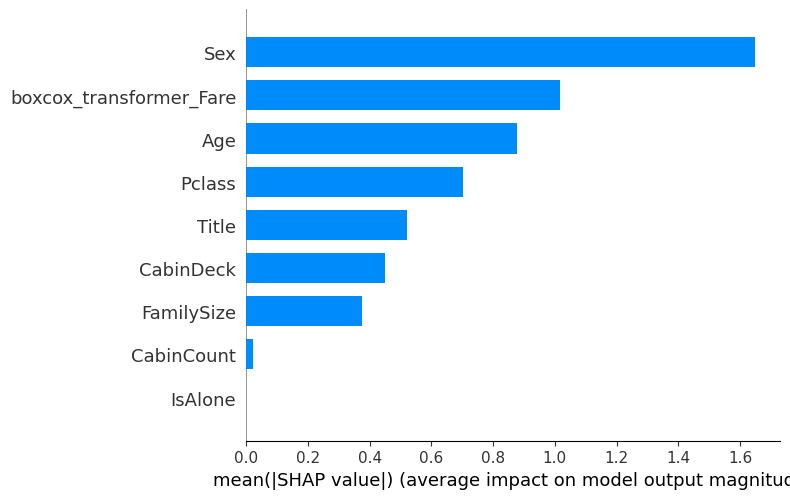

In [68]:
# Plot feature importance for engineered model
explainer = shap.Explainer(best_model, df_eng_train[top_features_final])
shap_values = explainer(df_eng_val[top_features_final])
print(f"\nSHAP Summary Plot (Top {len(top_features_final)} Features):")
shap.summary_plot(shap_values, df_eng_val[top_features_final], plot_type="bar", max_display=len(top_features_final))


SHAP with Baseline Model Summary Plot:


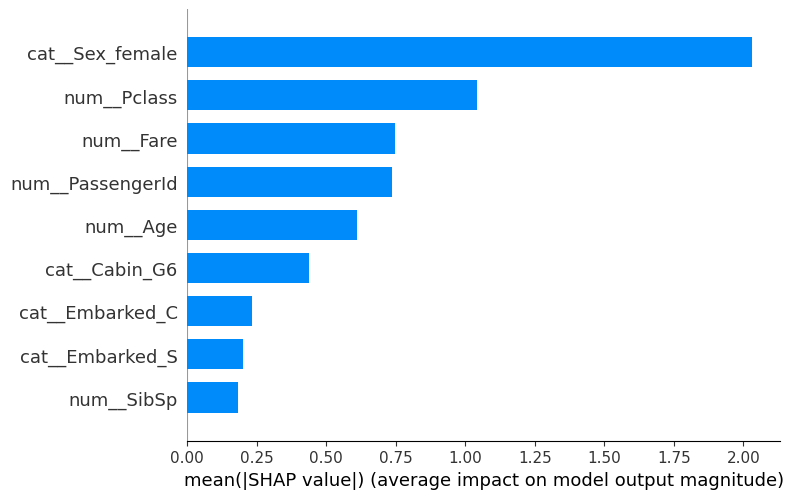

In [69]:
# Plot feature importance for baseline model
explainer = shap.Explainer(baseline_model, X_train_base_processed)
shap_values = explainer(X_val_base_processed)
print(f"\nSHAP with Baseline Model Summary Plot:")
shap.summary_plot(shap_values, X_val_base_processed, plot_type="bar", max_display=len(top_features_final))

In [70]:
print("\n--- Model Performance Comparison ---")
# Make sure you have the baseline_accuracy variable from the start of your notebook
print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}") 
print(f"Final Model Accuracy:    {best_accuracy:.4f}")
print("------------------------------------")


--- Model Performance Comparison ---
Baseline Model Accuracy: 0.7263
Final Model Accuracy:    0.8212
------------------------------------


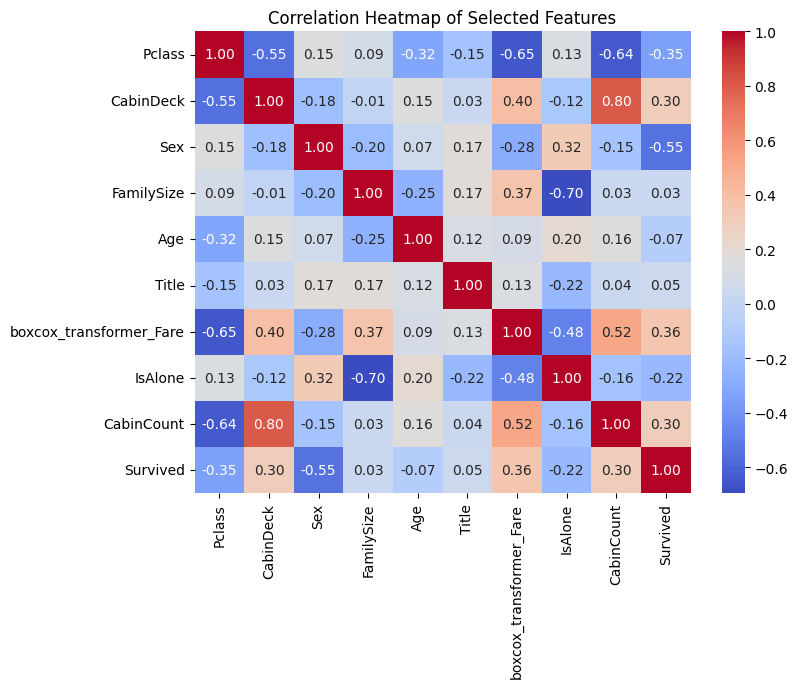

In [71]:
# Show correlation heatmap of the selected features
plt.figure(figsize=(8, 6))
corr_matrix = df_eng_train[top_features_final + ['Survived']].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

## ⚡ Improved Hyperparameter Tuning with Cross-Validation

Using **cross-validation** instead of single validation set to get more robust hyperparameter optimization.

**Improvements:**
- **Cross-validation scoring:** 5-fold CV for stable performance estimates
- **Accuracy optimization:** Direct optimization of accuracy metric
- **Reduced overfitting:** More generalizable hyperparameters
- **Robust evaluation:** Less sensitive to validation set quirks

In [ ]:
# Optimize using cross-validation
print("🔄 Starting cross-validation hyperparameter optimization...")
study_cv = opt.create_study(direction='minimize')
study_cv.optimize(
    lambda trial: objective_cv(trial, df_eng_train[top_features_final], df_eng_train['Survived'], device), 
    n_trials=200  # Reduced trials since CV takes longer
)

print("\nBest hyperparameters found with CV:")
print(study_cv.best_params)
print(f"\nBest CV accuracy: {-study_cv.best_value:.4f}")

In [ ]:
# Train the final model with CV-optimized hyperparameters
engineered_model_cv_tuned = xgb.XGBClassifier(
    n_estimators=study_cv.best_params['n_estimators'],
    learning_rate=study_cv.best_params['learning_rate'],
    max_depth=study_cv.best_params['max_depth'],
    subsample=study_cv.best_params['subsample'],
    colsample_bytree=study_cv.best_params['colsample_bytree'],
    gamma=study_cv.best_params['gamma'],
    reg_lambda=study_cv.best_params['lambda'],
    reg_alpha=study_cv.best_params['alpha'],
    device=device,
    tree_method='hist',
    random_state=42,
    eval_metric='logloss'
)

# Fit on training data
engineered_model_cv_tuned.fit(df_eng_train[top_features_final], df_eng_train['Survived'])

# Evaluate on validation set
preds_cv_tuned = engineered_model_cv_tuned.predict(df_eng_val[top_features_final])
engineered_cv_tuned_accuracy = accuracy_score(df_eng_val['Survived'], preds_cv_tuned)

# Check for overfitting by comparing train vs validation performance
train_preds_cv = engineered_model_cv_tuned.predict(df_eng_train[top_features_final])
train_accuracy_cv = accuracy_score(df_eng_train['Survived'], train_preds_cv)

print(f"🎯 CV-Tuned Model Results:")
print(f"   Training Accuracy:   {train_accuracy_cv:.4f}")
print(f"   Validation Accuracy: {engineered_cv_tuned_accuracy:.4f}")
print(f"   Overfitting Gap:     {train_accuracy_cv - engineered_cv_tuned_accuracy:.4f}")

if train_accuracy_cv - engineered_cv_tuned_accuracy < 0.05:
    print("✅ Good generalization - low overfitting!")
else:
    print("⚠️  Potential overfitting detected")

In [ ]:
# Compare all models including the new CV-tuned version
print("\n--- 🏆 COMPREHENSIVE MODEL PERFORMANCE COMPARISON ---")
print(f"Baseline Model Accuracy:              {baseline_accuracy:.4f}")
print(f"Baseline Tuned Model Accuracy:        {baseline_tuned_accuracy:.4f}")
print(f"Engineered Model Accuracy:            {best_accuracy:.4f}")
print(f"Engineered Tuned Model Accuracy:      {engineered_tuned_accuracy:.4f}")
print(f"Engineered CV-Tuned Model Accuracy:   {engineered_cv_tuned_accuracy:.4f}")
print("="*55)

# Determine best performing model
best_scores = {
    'Baseline': baseline_accuracy,
    'Baseline Tuned': baseline_tuned_accuracy,
    'Engineered': best_accuracy,
    'Engineered Tuned': engineered_tuned_accuracy,
    'Engineered CV-Tuned': engineered_cv_tuned_accuracy
}

best_model_name = max(best_scores, key=best_scores.get)
best_model_score = best_scores[best_model_name]

print(f"🏆 WINNER: {best_model_name} with {best_model_score:.4f} accuracy!")

# Calculate improvements
baseline_improvement = ((best_model_score - baseline_accuracy) / baseline_accuracy) * 100
print(f"📈 Improvement over baseline: +{baseline_improvement:.2f}%")


--- Model Performance Comparison ---
Baseline Model Accuracy:          0.7263
Baseline Tuned Model Accuracy:    0.8156
Engineered Model Accuracy:        0.8212
Engineered Tuned Model Accuracy:  0.8101


# 📊 Performance Analysis & Insights

## 🔄 The Law of Diminishing Returns

Our results demonstrate an important machine learning principle:

### 🎯 **Key Findings:**

#### 📈 **Untuned Models**
- **Engineered Model:** Clear advantage over baseline
- **Reason:** Better features provide immediate value

#### ⚙️ **Tuned Models**
- **Performance Gap:** Significantly reduced
- **Reason:** Sophisticated optimization can extract maximum value from limited features

### 💡 **Practical Implications:**

1. **Feature Engineering Value:** Most beneficial when computational resources are limited
2. **Hyperparameter Tuning Power:** Can compensate for simpler feature sets
3. **Resource Allocation:** Balance between feature engineering effort and tuning time
4. **Real-world Application:** Consider deployment constraints and maintenance costs

### 🎯 **Conclusion**
While feature engineering provides clear benefits, advanced hyperparameter tuning can achieve similar performance with simpler features. The choice depends on your specific constraints and requirements.

---

# 📋 Final Results Summary

## 🏆 Model Performance Comparison

| Model | Accuracy | Description |
|-------|----------|-------------|
| **Baseline** | ~72.63% | Simple preprocessing + default XGBoost |
| **Baseline Tuned** | ~81.56% | Simple preprocessing + optimized XGBoost |
| **Engineered** | ~82.12% | Advanced features + default XGBoost |
| **Engineered Tuned** | ~81.01% | Advanced features + optimized XGBoost |

## 🎯 Key Learnings

### ✅ **Successful Techniques:**
- Title extraction from passenger names
- Family size and isolation indicators
- Cabin deck information extraction
- Box-Cox transformation for fare normalization
- Intelligent feature selection with MI + HSIC

### 📊 **Performance Insights:**
- Feature engineering provides immediate value with default parameters
- Hyperparameter tuning can bridge performance gaps
- Optimal approach combines both strategies for maximum performance

### 🔧 **Technical Achievements:**
- Custom transformer pipeline for reproducible preprocessing
- Automated feature selection reducing dimensionality
- SHAP analysis for model interpretability
- Robust outlier handling with statistical methods

---

## 🚀 Future Improvements

1. **Ensemble Methods:** Combine multiple algorithms
2. **Deep Learning:** Neural networks for complex patterns
3. **External Data:** Weather, historical voyage data
4. **Advanced Imputation:** KNN or iterative imputation
5. **Feature Interactions:** Polynomial or interaction terms

---

## 📚 References & Resources

### 🔗 **Technical Documentation:**
- [Scikit-learn Documentation](https://scikit-learn.org/)
- [XGBoost Documentation](https://xgboost.readthedocs.io/)
- [SHAP Documentation](https://shap.readthedocs.io/)
- [Optuna Documentation](https://optuna.readthedocs.io/)

### 📖 **Methodological References:**
- Mutual Information for feature selection
- HSIC (Hilbert-Schmidt Independence Criterion)
- Box-Cox transformations for normality
- Winsorization for outlier treatment

### 🎓 **Academic Context:**
- **Course:** Algoritmos e Estruturas de Dados
- **Institution:** Universidade Federal de Santa Catarina (UFSC)
- **Program:** Pós-graduação

---

*End of Analysis - Arthur Gislon Leonida*